<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher/blob/master/examples/WW-Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Analyzing the performance of the Albert models using weightwatcher

ALBERT exhbits many features of the theory, including 
- the layer metrics are nearly all very well correlated with various NLP quality metrics
- layers with alpha ~ 2 can show theoretcially perfect behavior

but (or and) it has some of the common gotchas you have to watch out for
 - there are layers exhbiting  rank collapse
 - at least 1 layer (in xxlarge) has a bad Power lw fit, and needs to be corrected 

The 4 pretrained models are traken from the Huggingface Repo:

https://huggingface.co/albert-base-v2

<pre>
    V2	    Average	SQuAD1.1	SQuAD2.0	MNLI	SST-2	RACE					
ALBERT-base	   82.3	90.2/83.2	82.1/79.3	84.6	92.9	66.8
ALBERT-large	  85.7	91.8/85.2	84.9/81.8	86.5	94.9	75.2
ALBERT-xlarge	 87.9	92.9/86.4	87.9/84.1	87.9	95.4	80.7
ALBERT-xxlarge	90.9	94.6/89.1	89.8/86.9	90.6	96.8	86.8
</pre>

Each ALBERT model has the same number of layers

This lets us see how the invidual layer eigenvalues / spectral properties change with an increasingly complex model, trained with more data.

We then take a deep dive to look at some of the anamolies and what can be done about them


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install transformers  gwpy matplotlib==3.1.3


In [3]:
from transformers import AutoModel


In [4]:
!python3 -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple weightwatcher


Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [5]:
import weightwatcher as ww
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(ww.__name__) 
logger.setLevel(logging.INFO)


### We will just use the mean accuracies, understanding that there is some variance

In [6]:
versions = ['base', 'large', 'xlarge','xxlarge']
mean_qualities = [82.3, 85.7, 87.9, 90.9]

In [7]:
%%capture

from transformers import  AlbertModel

import warnings
warnings.filterwarnings('ignore')

all_details = []
for version in versions:
    model_name = f"albert-{version}-v2"
    albert = AlbertModel.from_pretrained(model_name)

    watcher = ww.WeightWatcher(model=albert)
    details = watcher.analyze(randomize=True, mp_fit=True, detX=True)
    all_details.append(details)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize

## Lets see how the layer-averaged metrics compare to the model 'accuracies'

We can form layer-averaged metrics directly from the details dataframe

### We can plot the average model quality agains the  (IVW) mean alpha 

- alpha is the weightwatcher PL tail exponent

- sigma is the varince of the alpha fit

- quality is the average model quality  (above)

- IVW is the inverse variance weighted average

- we remove $\alpha$ outliers $(\alpha < 1.5)$ and $(\alpha > 8)$, which is the range of the PL estimator


The $\alpha$ metric is reasonably well correlated with the average quality, but the largest model (xxlarge) is an outlier (or, rather, the xlarge model has unexpectedly better alphas, which we see below correlates with having a better average *rand_distance* also)




Text(0.5, 0, 'Average Model quality')

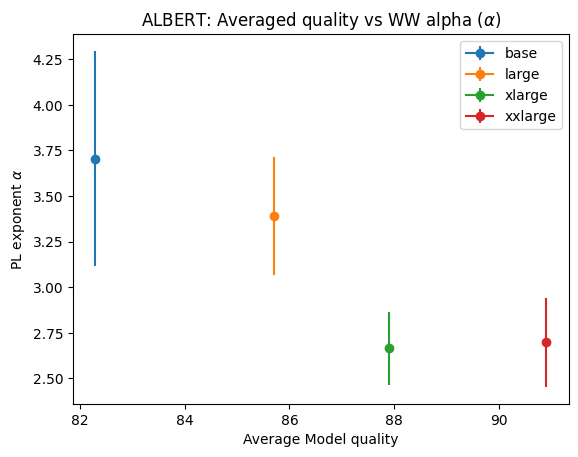

In [8]:
for idx, details in enumerate(all_details):
    version = versions[idx]
    mean_quality = mean_qualities[idx] 
    D = details[(details.alpha < 8) & (details.alpha > 1.5)]
    
    alphas = D.alpha.to_numpy()
    weights = 1.0/D.sigma.to_numpy()
    
    alpha = np.average(alphas, weights=weights)
    sigma = D.sigma.mean()
    
    plt.errorbar(mean_quality, alpha, yerr=sigma, label=version, marker='o')
plt.legend()
plt.title(r"ALBERT: Averaged quality vs WW alpha $(\alpha)$")
plt.ylabel(r"PL exponent $\alpha$")
plt.xlabel("Average Model quality")

### If we look at other weightwatcher metrics, however, they do correlate with the model qualities

For example we can look at the simple layer averaged:

  - log_spectral_norm
  - rand_distance (but there is an outlier with xlarge (Green))

Text(0.5, 0, 'Average Model quality')

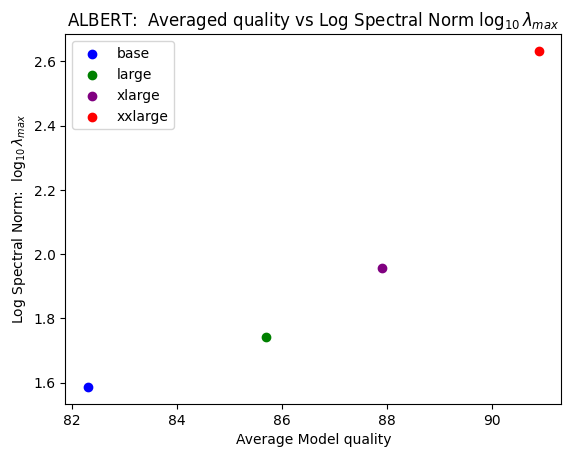

In [9]:
colors = ['blue','green', 'purple', 'red']
for idx, details in enumerate(all_details):
    version = versions[idx]
    color = colors[idx]
    mean_quality = mean_qualities[idx] 

    x = mean_quality
    y = details.log_spectral_norm.mean()

    plt.scatter(x, y, label=version, marker='o', color=color)
    
    
plt.legend()
plt.title(r"ALBERT:  Averaged quality vs Log Spectral Norm $\log_{10}\lambda_{max}$")
plt.ylabel(r"Log Spectral Norm:  $\log_{10}\lambda_{max}$")
plt.xlabel("Average Model quality")

Text(0.5, 0, 'Average Model quality')

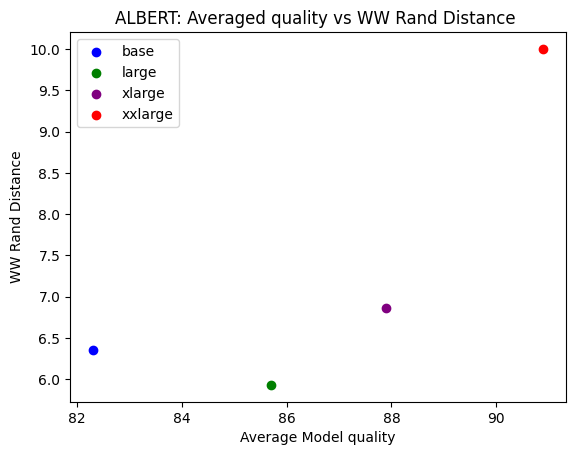

In [10]:
colors = ['blue','green', 'purple', 'red']
for idx, details in enumerate(all_details):
    version = versions[idx]
    color = colors[idx]
    
    mean_quality = mean_qualities[idx] 

    x = mean_quality  
    y = details.alpha_weighted.mean()
    
    plt.scatter(x, y, label=version, marker='o', color=color)
    
    
plt.legend()
plt.title(r"ALBERT: Averaged quality vs WW Rand Distance ")
plt.ylabel(r"WW Rand Distance")
plt.xlabel("Average Model quality")

### There appears to be some outliers wich need to be dealt with.

They could be real , or could be bad power lsw fits

To find the bad fits, we can look at the *Corrrelation Flow**


### Correlation Flow

Text(0.5, 0, 'Layer Id (Data -> Labels)')

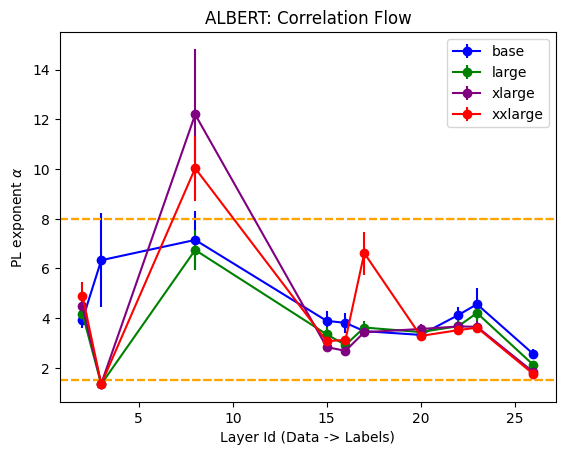

In [11]:
for idx, details in enumerate(all_details):
    version = versions[idx]
    color = colors[idx]
    
    x = details.layer_id.to_numpy()
    y = details.alpha.to_numpy()
    err = details.sigma.to_numpy()
    plt.errorbar(x, y, yerr=err, label=version, marker='o', color=color)
    plt.axhline(1.5, color='orange', linestyle='dashed')
    plt.axhline(8, color='orange', linestyle='dashed')
    
plt.legend()
plt.title(r"ALBERT: Correlation Flow")
plt.ylabel(r"PL exponent $\alpha$")
plt.xlabel("Layer Id (Data -> Labels)")

In [12]:
all_details[0].layer_id.to_frame()

,layer_id
0,2
0,3
0,8
0,15
0,16
0,17
0,20
0,22
0,23
0,26


### We see several anamolies :  

We need to determine of the 

  - layer 3 has alpha > 6 or < 2.  This suggests a bad fit , which will be due to Rank Collapse.
  
  
  - layer 8 is always an outlier $(\alpha > 6)$, suggesting that this layer is not Fat Tailed but only Weakly Heavy Tailed, and possibly undertrained.
  
  
  - layer 17 (xxlarge) shows *Scale Collapse*.  This could be real, but is actually just a bad PL fit.  This is an example of where there are nearly degenerate 2 global minima (as in the SETOL paper, Figure 1).

### Lets look at each layer and analyze the problems


### Layer 3:  is clearly rank collapse

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize



python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1


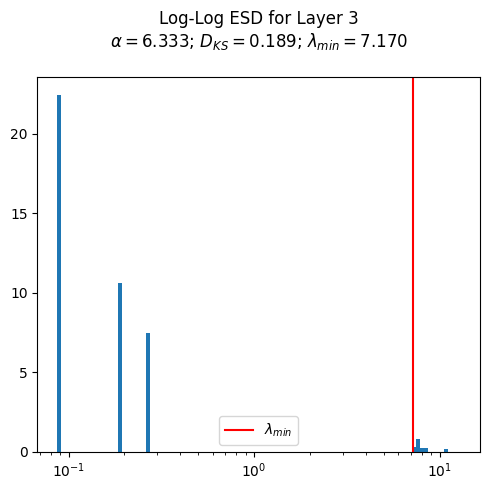

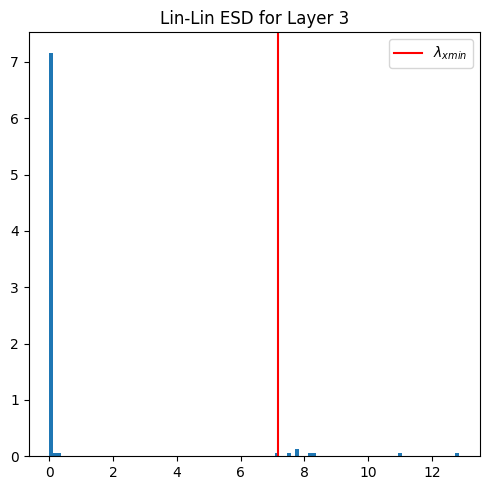

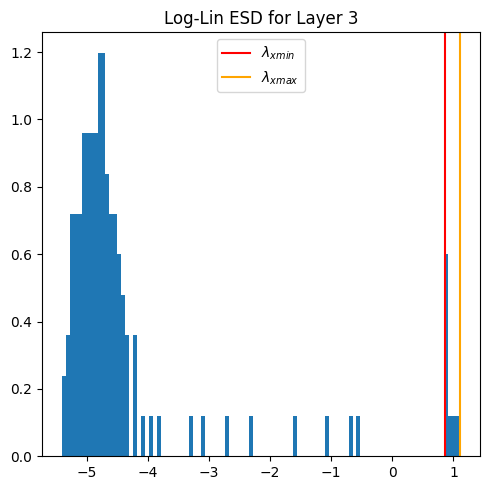

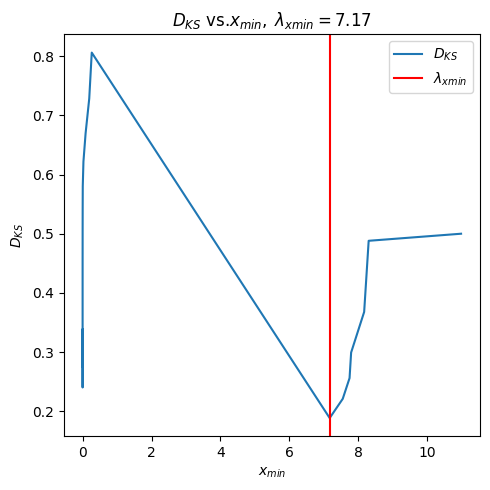

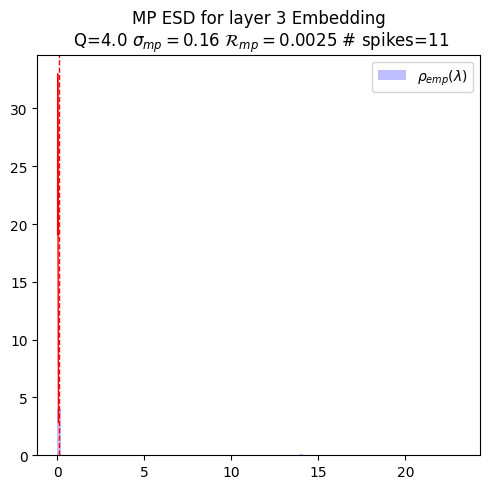

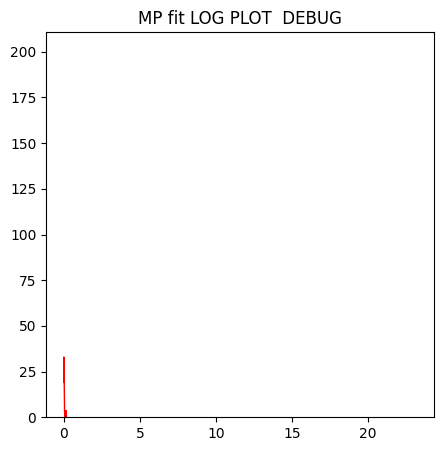

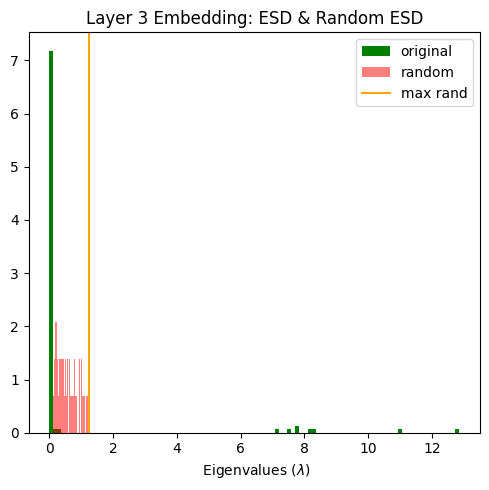

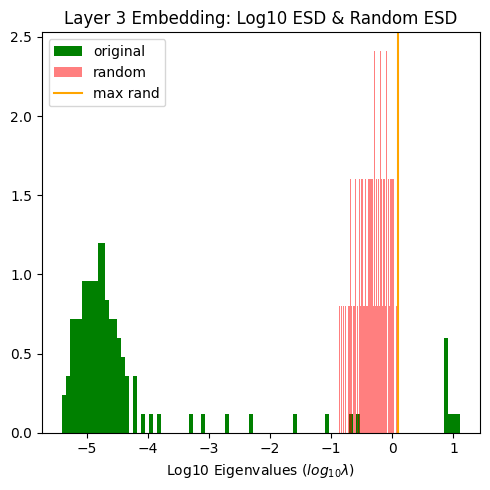

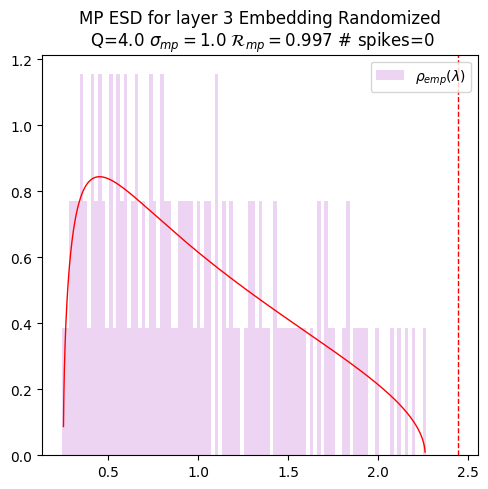

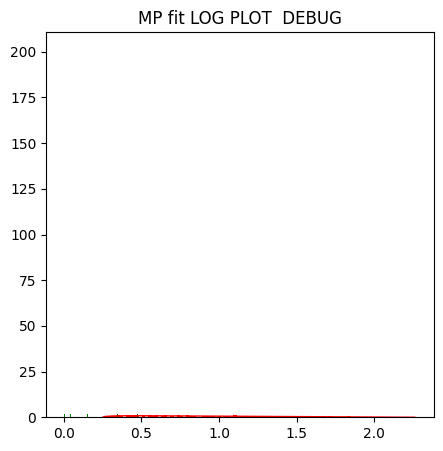

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

model_name = f"albert-base-v2"
albert = AutoModel.from_pretrained(model_name)

watcher = ww.WeightWatcher(model=albert)
tpl_details = watcher.analyze(layers=[3], randomize=True, mp_fit=True, plot=True)

Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normal



python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1


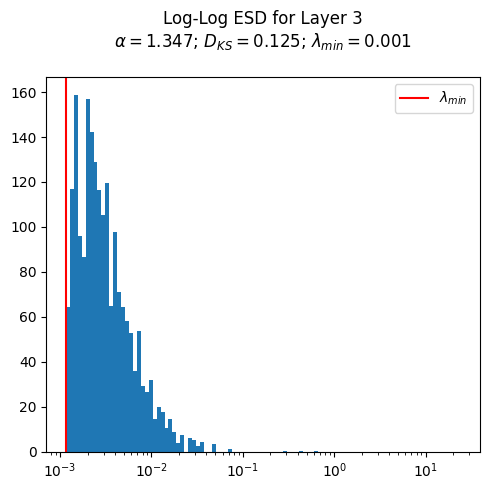

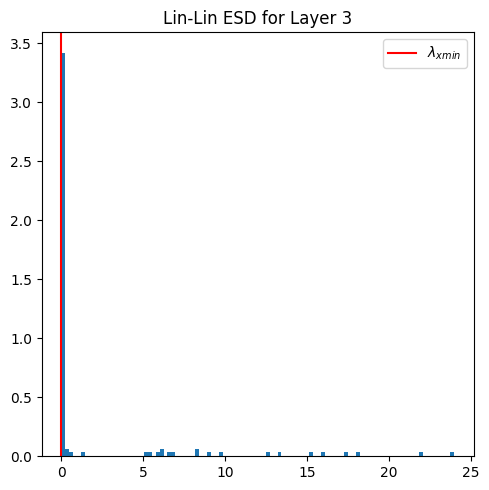

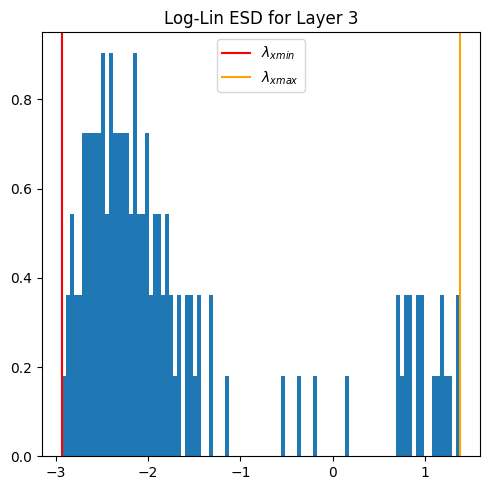

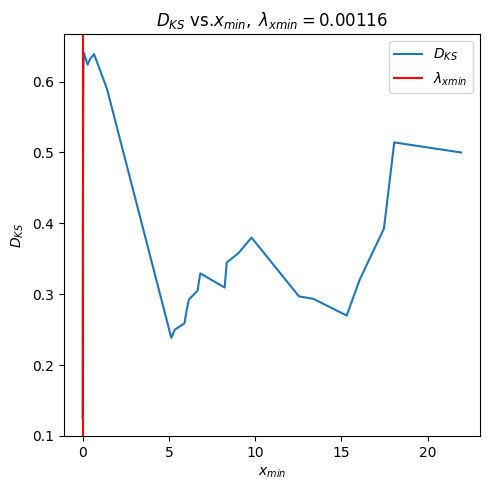

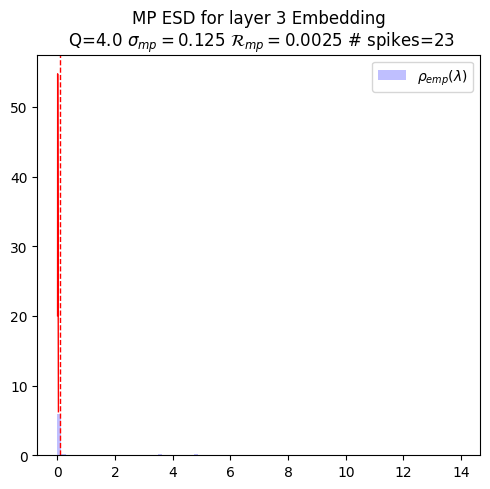

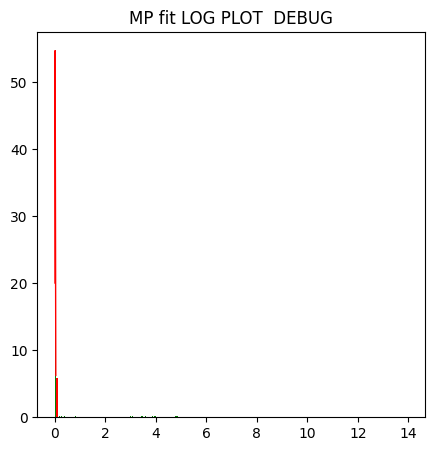

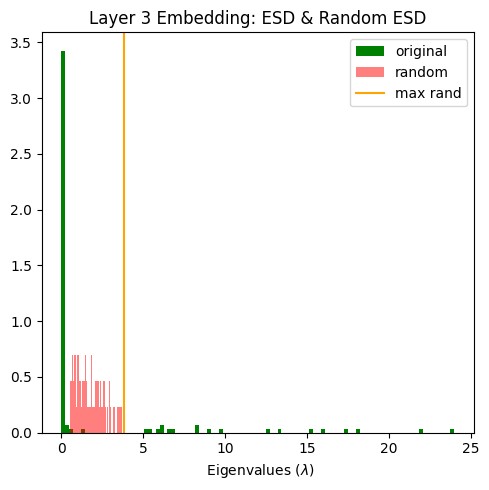

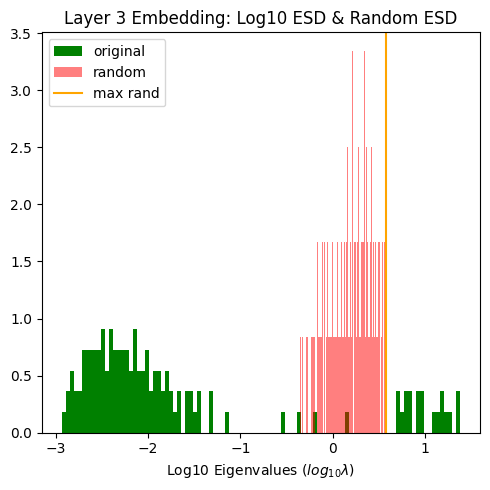

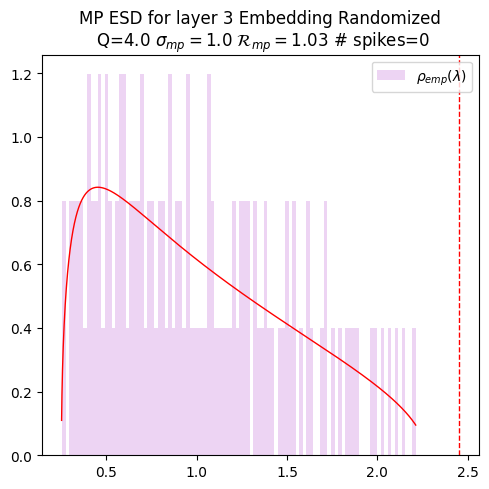

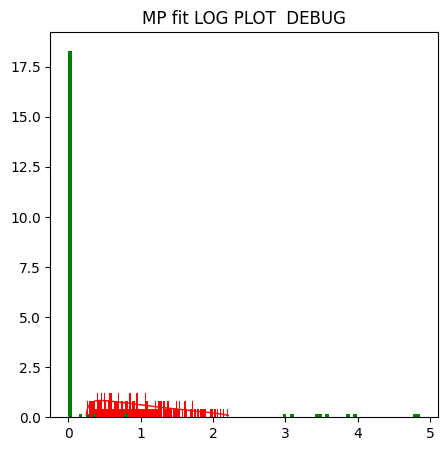

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

model_name = f"albert-xxlarge-v2"
albert = AutoModel.from_pretrained(model_name)

watcher = ww.WeightWatcher(model=albert)
details_3 = watcher.analyze(layers=[3], randomize=True, mp_fit=True, plot=True)

### Layer 8

Layer 8 alo shows some rank collpae and appears to be *Bulk + Spikes* and not even Weakly Heavu Tailed

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': True, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [8], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 8


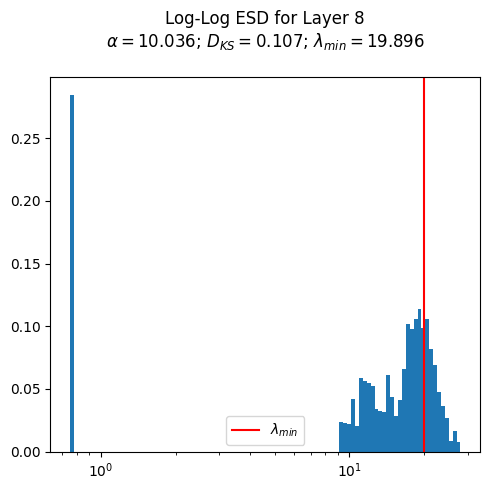

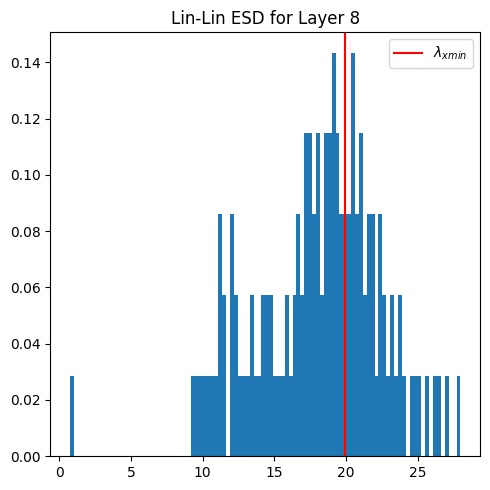

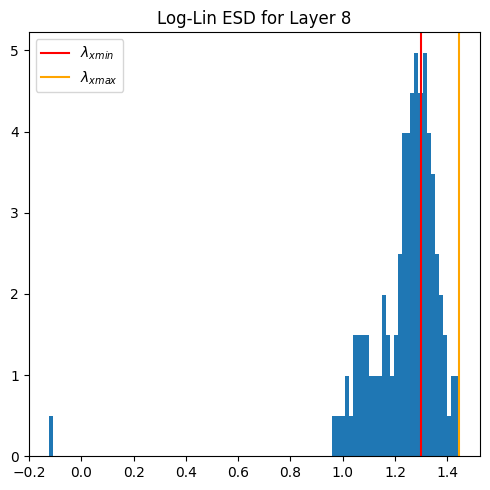

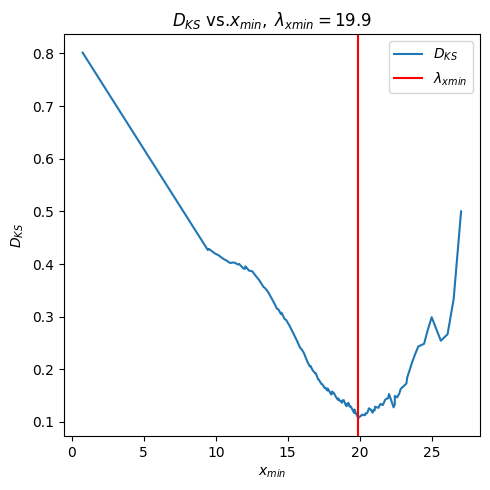

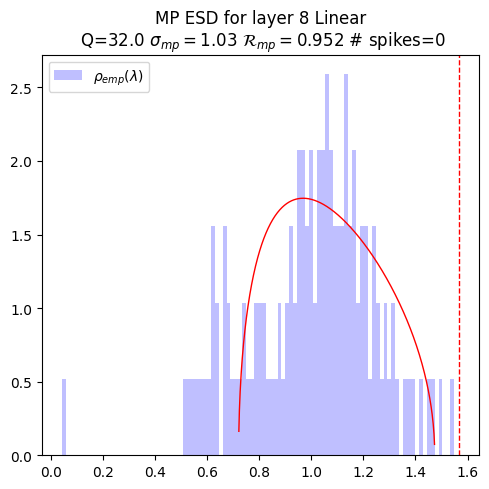

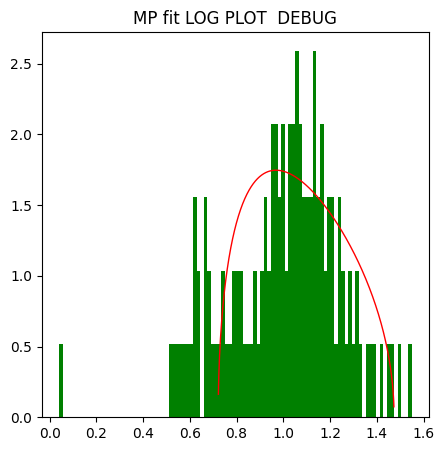

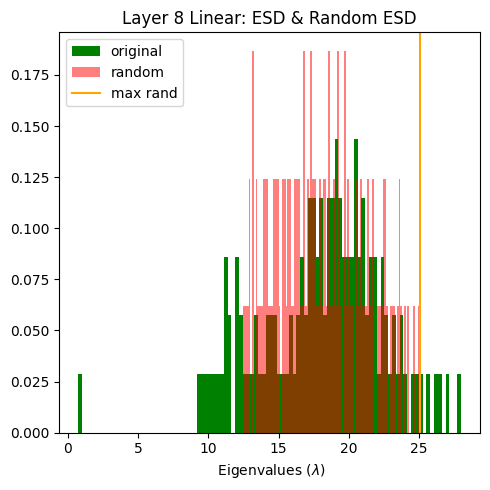

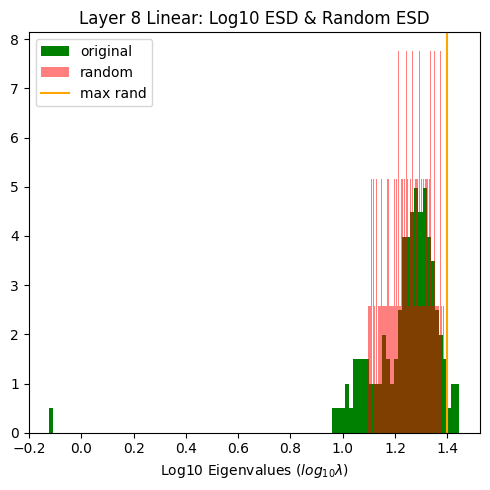

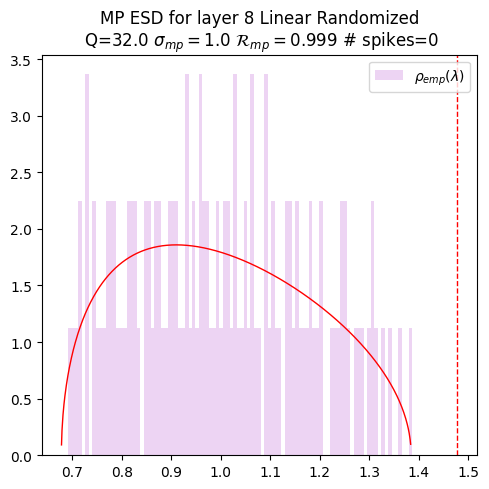

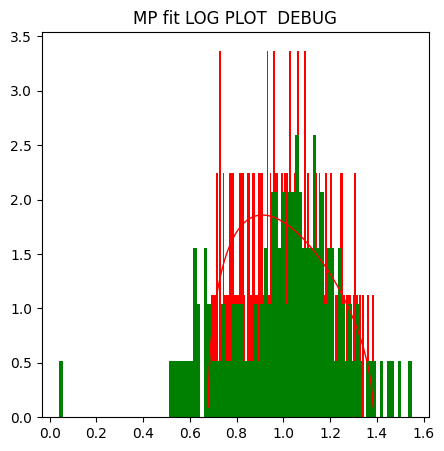

In [15]:
details_8 = watcher.analyze(layers=[8], randomize=True, mp_fit=True, plot=True)

### Layer 17 xxlarge

Layer 17 xxlarghe has a bad power lsw fit compared to other models, which can be seen 

- on the Log-Log plot, because the tail is so snall (the red line is so far to the right)

- in the $D_{KS$ vs xmin plot, which shows 2 gnearly degenerate minimum (as in the SETOL paper, Figure 1)

This can happen where is noise in the far end of the tail, which sometimes presumably due to some correlated spikes peaking out.  




INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': True, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [17], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 17


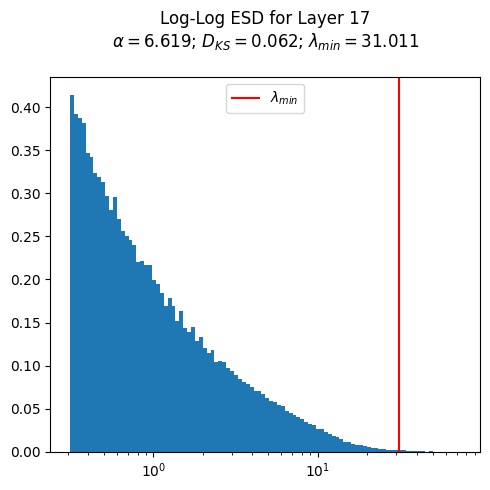

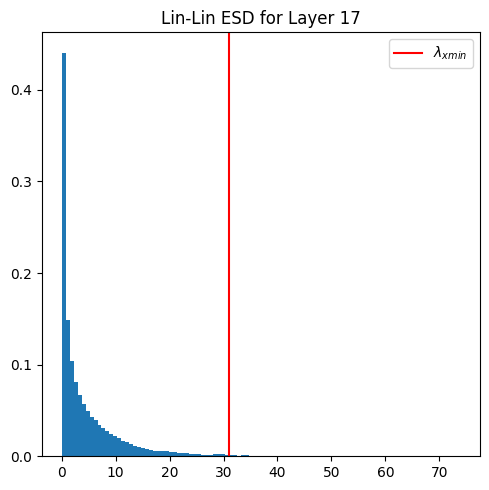

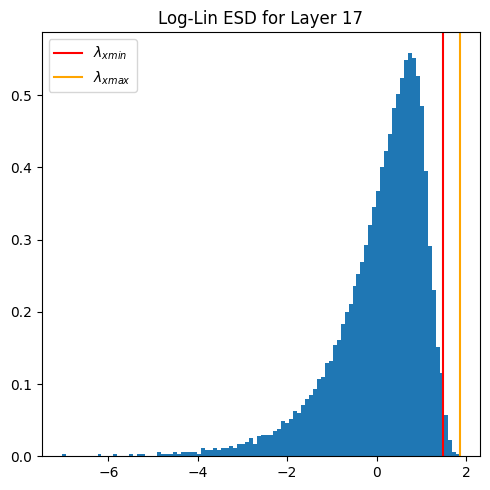

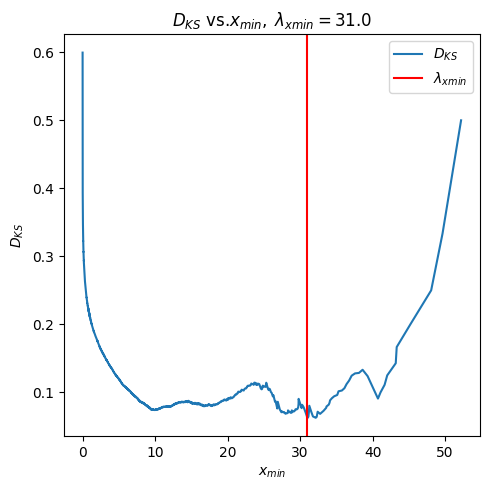

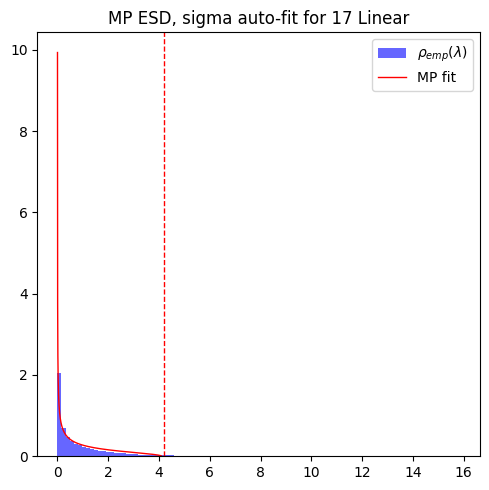

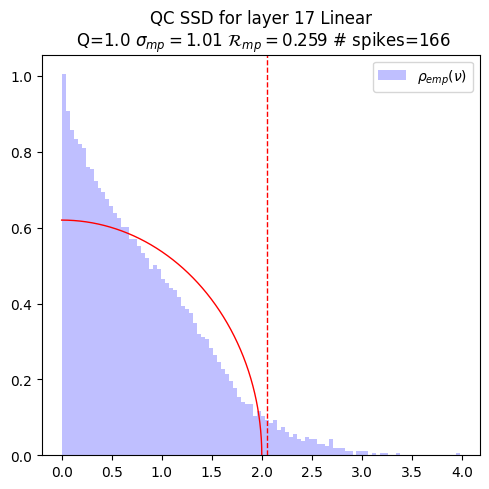

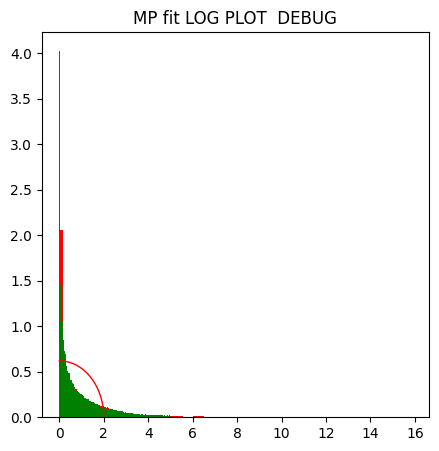

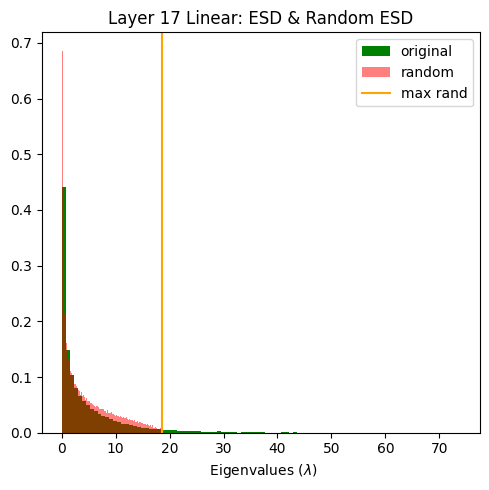

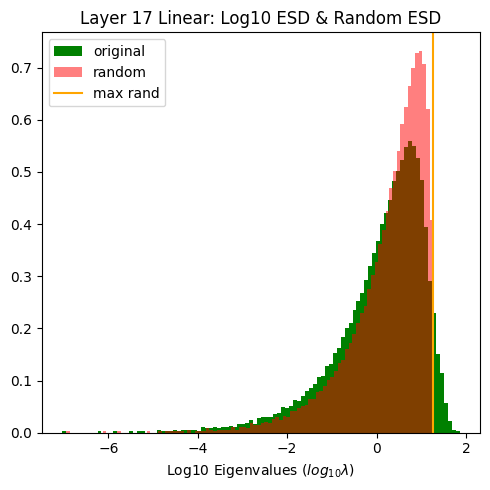

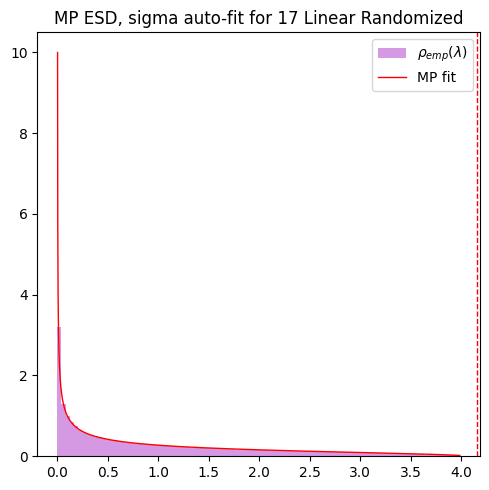

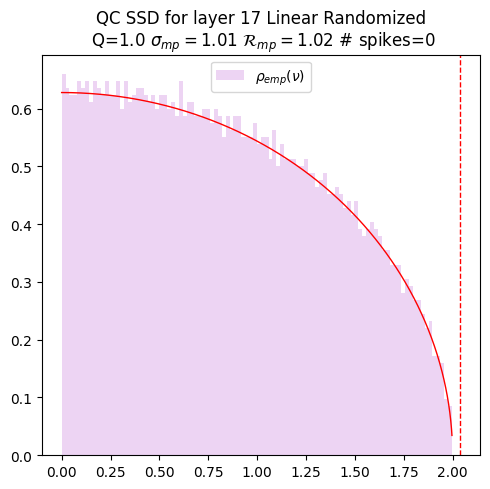

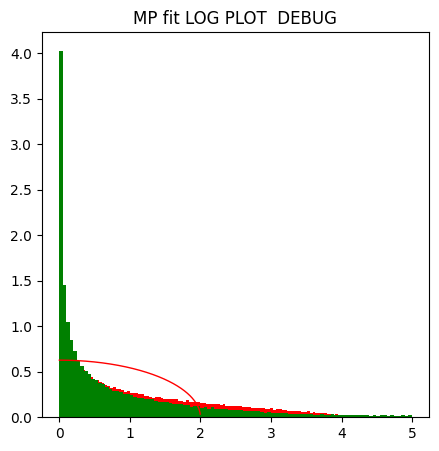

In [16]:
details_17 = watcher.analyze(layers=[17], randomize=True, mp_fit=True, plot=True)

### More ahout Layer 17
The Log-Log plot is also looks like an exponentially decaying ESD , and a better look can be foind by just using a a different plot function (which is bot yet in weightwatcher (see below) where it. can be seen that the tail of the ESd really is most power law, with some noise in the largest eigenvalue

This is not surprising.  Sometimes we see 'fingers' stick out from the ESD.

INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': False, 'min_evals': 0, 'max_evals': None, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'f

Text(0.5, 1.0, 'ALBERT xxlarge, Log-Log Layer 17')

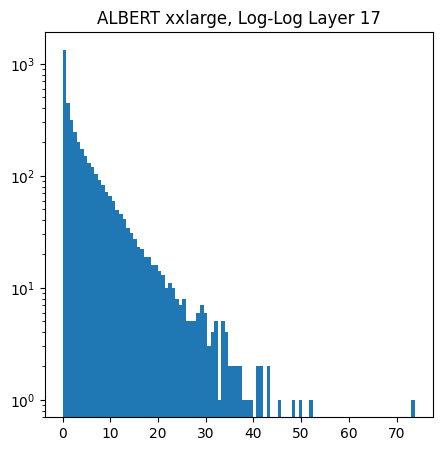

In [17]:
esd = watcher.get_ESD(layer=17)
plt.hist(esd, log=True, bins=100);
plt.title("ALBERT xxlarge, Log-Log Layer 17")

### Fixing Layer 17   -- is it a Truncated Power Law (TPL) ?

The Layer 17 ESD is probably really a Truncated Power Law, and if we use fit='TPL', 
we do fit a TPL well, with alpha=1.0 .  But this is not very useful 

But we we can see is tht if we fit a TPL, we can see that the tail starts much earlier,

and on the Log-Lin plot,  the xmin setting  (red line) is close to the peak of the ESD 


#### Warning--the TPL fits are **very slow**   I don't suggest running this

But this result suggests we can use the PL method, if we restrict the 


### Fixxing 'Fingers'

When the tail has this nose, we call these 'fingers' , and the *fix_fingers* options can fix it, but it is not fully automated yet, and soetimes you have to 'eyeball it'.  We have 2 options for watcher.analyze()

    1) fix_fingers='xmin_peak', xmin_max = 15
    
    2) fix_fingers='clip_xmax' 


That is you can ask weightwatcher to try to clip the eigenvalues automatically, or

you can set the range for xmin, the maximum range of where the tail can start.

First, lets try the manual version

#### 2 )  fix_fingers='xmin_peak', xmin_max = 15

Set xmin_max = 15, which we found by looking at the plot $D_{KS}$ vs min and picked the local mimim for xmin that we found worked well with the other 3, smaller models

Eventually we hope to automate all of this but for now, sometimes the user has to make the change specifically 

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  xmin_peak
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': 'xmin_peak', 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': True, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [17], 'xmin_max': 15}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  xmin_peak
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 17
INFO:weightwatcher:fix the fingers by setting xmin to the peak of t

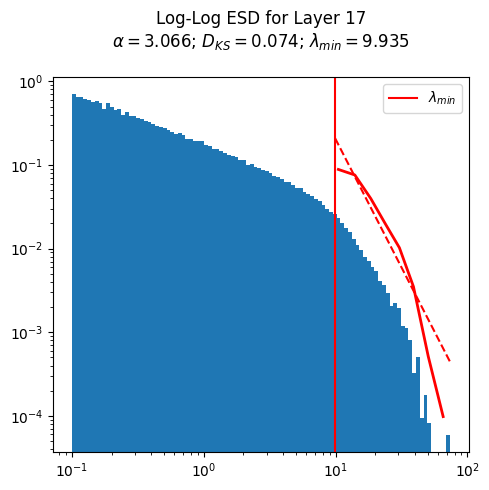

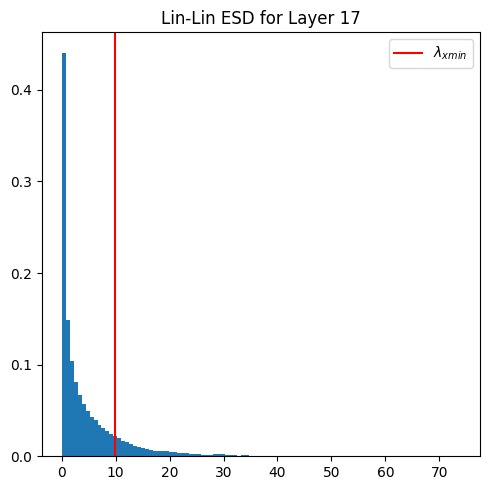

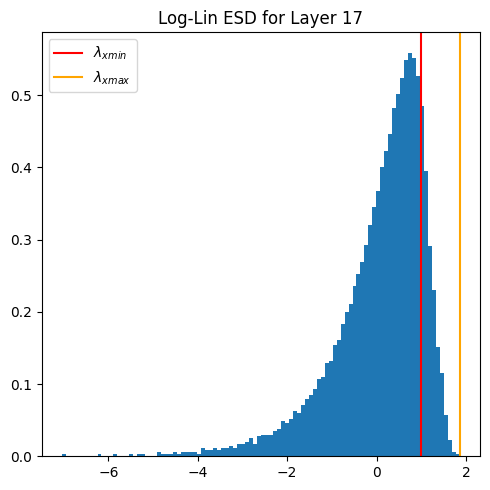

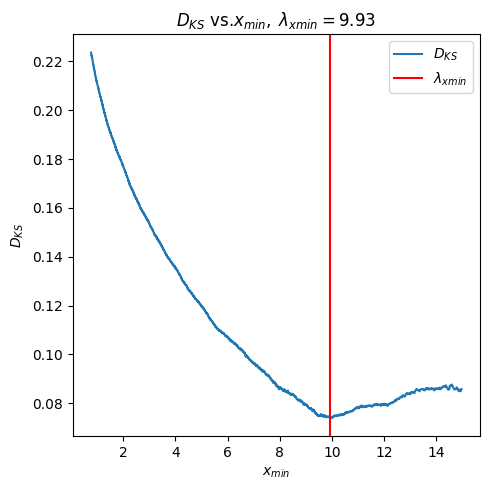

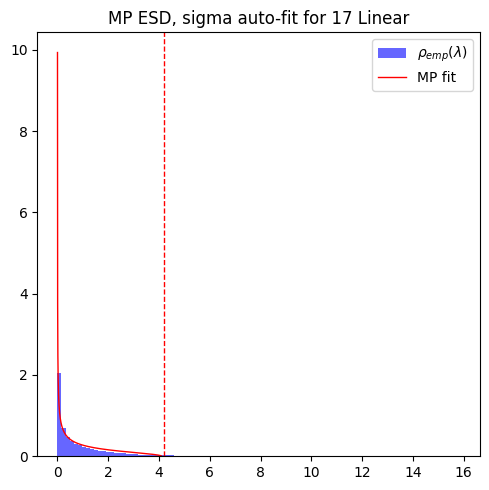

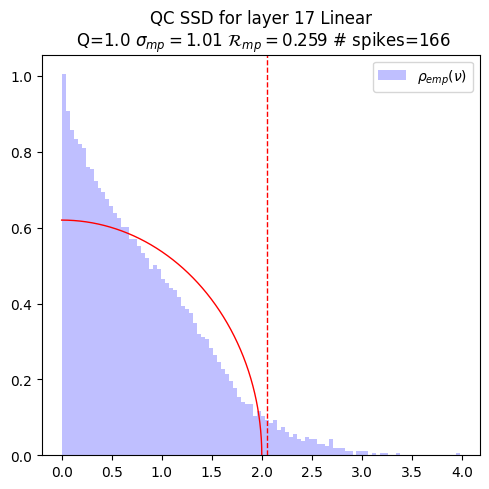

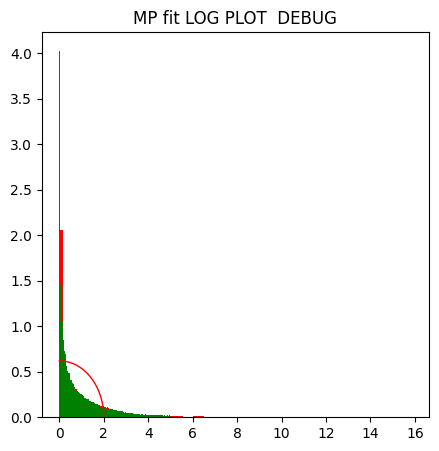

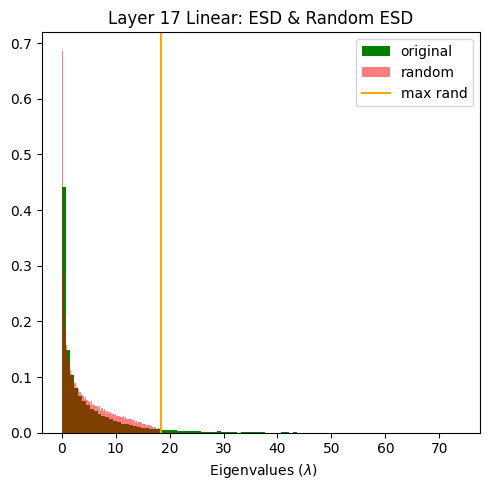

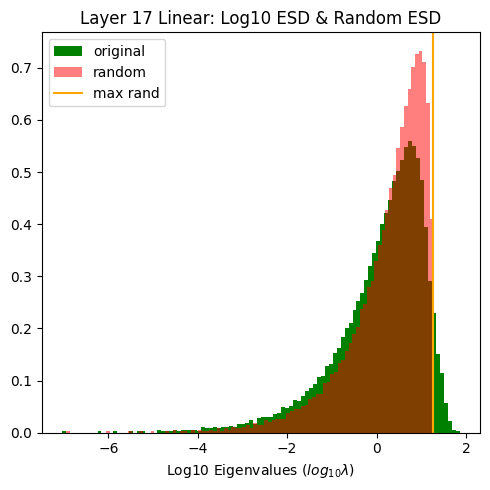

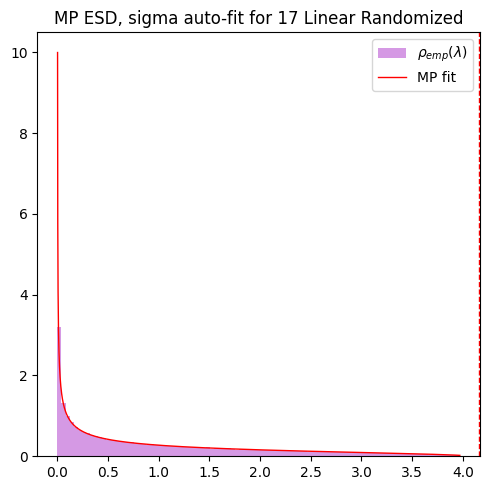

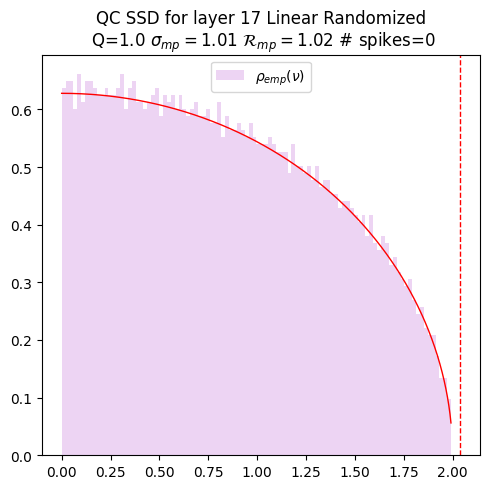

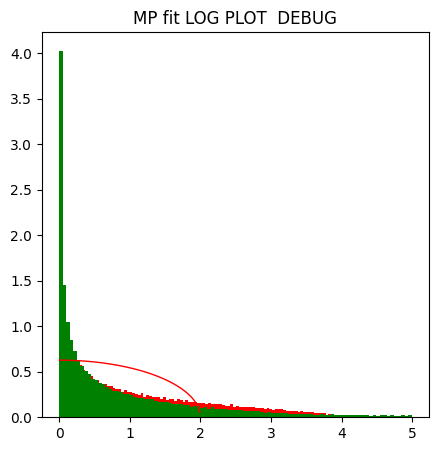

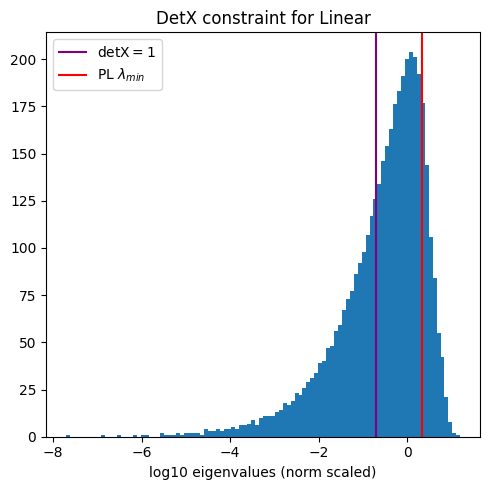

<Figure size 500x500 with 0 Axes>

In [18]:
details_17_xxlarge = watcher.analyze(layers=[17], fix_fingers='xmin_peak', xmin_max = 15, plot=True, randomize=True, mp_fit=True, detX=True)


#### 2 )  fix_fingers='clip_xmax'

Now, lets try the automated approach (which is a bit slower) and see how it compares to the manual adjustment

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  clip_xmax
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': 'clip_xmax', 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': True, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [17], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  clip_xmax
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 17
INFO:weightwatcher:fix the fingers by fitting a clipped power law

max N = 10
Calculating best minimal value for power law fit


Assuming nested distributions
INFO:weightwatcher:fit alpha 6.62 sigma 0.87 TPL or PL? 0.1547


Assuming nested distributions
INFO:weightwatcher:2 fit alpha 3.0243 sigma 0.0802 TPL or PL? 6.4508
INFO:weightwatcher:2 fit alpha 3.02 sigma 0.08 TPL or PL? 6.4508
INFO:weightwatcher:stopping at 2 3.02 << 6.62 


checking alpha


INFO:weightwatcher:checking fit 3 xmax 49.6310  alpha 3.02 sigma 0.08


INFO:weightwatcher:checking fit 4 xmax 48.0661  alpha 3.02 sigma 0.08


INFO:weightwatcher:checking fit 5 xmax 45.1959  alpha 3.02 sigma 0.08


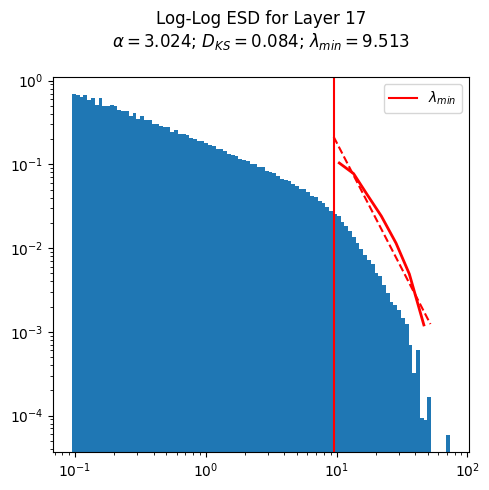

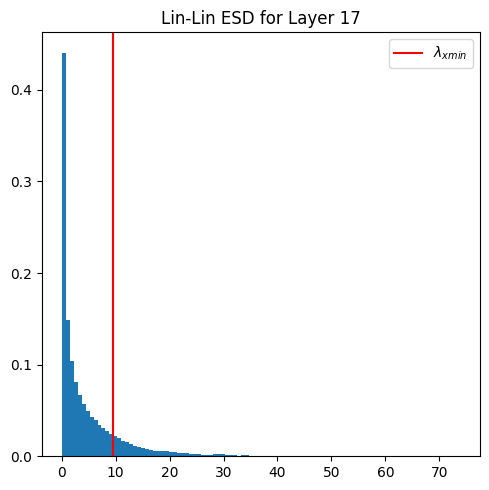

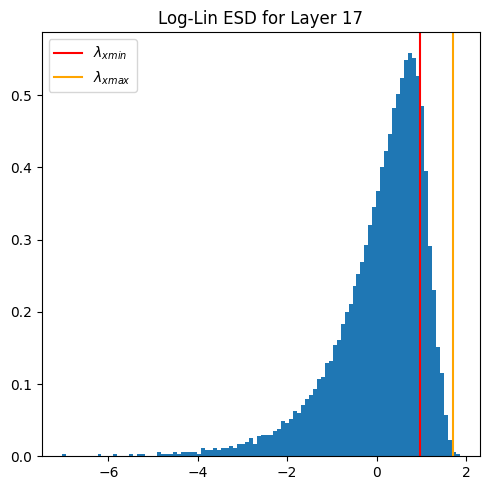

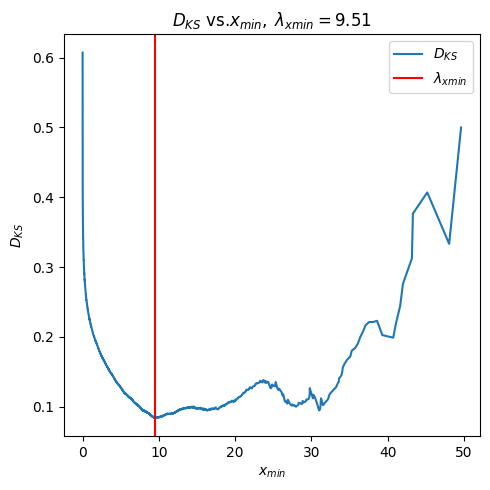

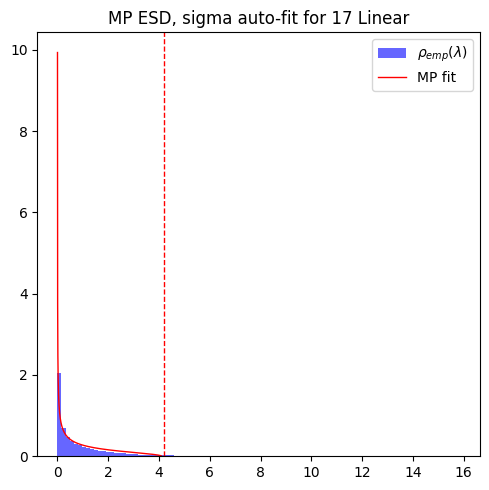

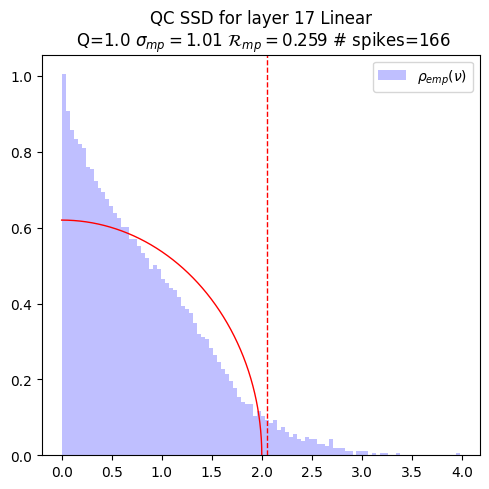

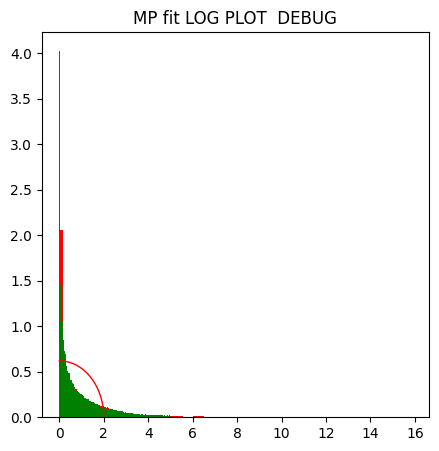

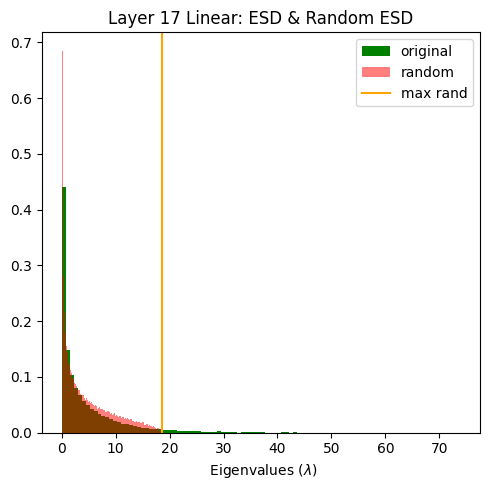

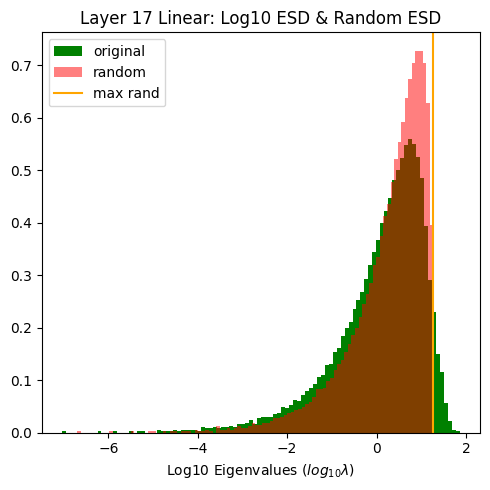

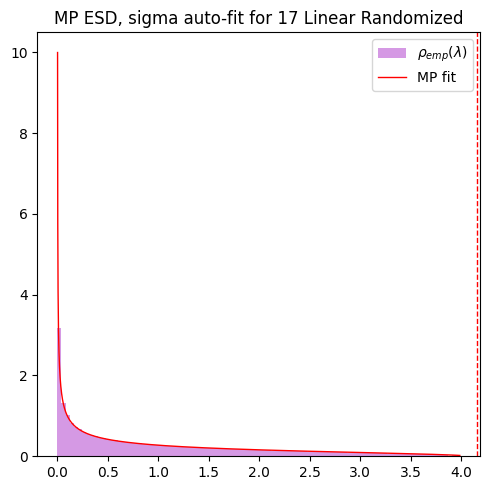

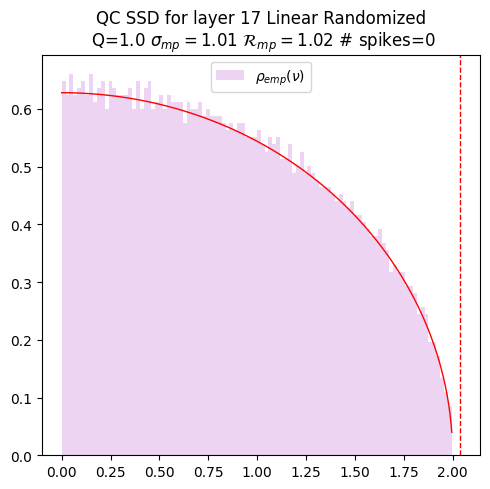

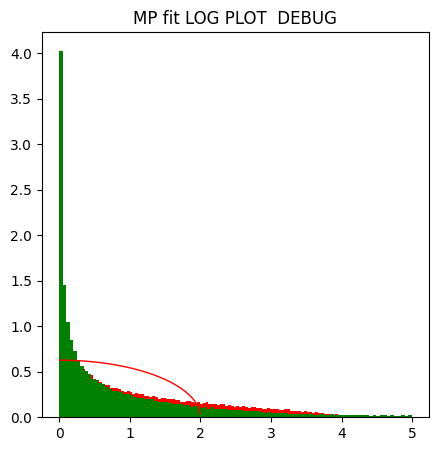

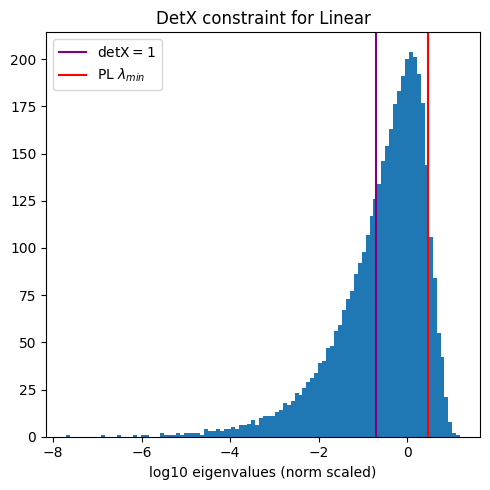

<Figure size 500x500 with 0 Axes>

In [19]:
details_17_xxlarge = watcher.analyze(layers=[17], fix_fingers='clip_xmax', plot=True, randomize=True, mp_fit=True, detX=True)


### Lets compare the manual and automated fixes

    1) alpha = 3.066
    
    2) alpha = 3.024

#### Ok, that's pretty good!

### Fix the details dataframe

Lets fix the xxlarge details dataframe, replace layer 17 with the new details dataframe

In [20]:
details_xxlarge = all_details[3]
mask = details_xxlarge.layer_id!=17
all_details[3] = pd.concat([details_xxlarge[mask], details_17_xxlarge])
all_details[3] = all_details[3].sort_values('layer_id')
all_details[3]

,layer_id,name,D,Lambda,M,N,Q,W_scale,alpha,alpha_weighted,...,sigma_mp,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,2,Embedding,0.051072,-1.0,128.0,30000.0,234.375,0.072832,4.906062,15.609098,...,0.533216,1519.128206,15.884396,38.975995,success,0.0,1167.124932,0.231714,1519.128206,217.708299
0,3,Embedding,0.125254,-1.0,128.0,512.0,4.000,0.762700,1.347109,1.859068,...,0.124524,23.990687,9.171908,4.898029,over-trained,0.0,20.194156,0.158250,23.990687,0.001159
0,8,Linear,0.107445,-1.0,128.0,4096.0,32.000,0.235277,10.035540,14.519316,...,1.031595,27.976264,82.653166,5.289259,under-trained,0.0,3.011387,0.892359,27.976264,19.896275
0,15,Linear,0.020501,-1.0,4096.0,4096.0,1.000,0.247841,3.073237,8.035094,...,1.010816,411.659520,161.985189,20.289394,success,2.0,346.615402,0.158005,411.659520,44.608659
0,16,Linear,0.018817,-1.0,4096.0,4096.0,1.000,0.249638,3.126629,8.168832,...,1.011313,409.887348,160.351410,20.245675,success,2.0,345.899388,0.156111,409.887348,45.709827
0,17,Linear,0.083720,-1.0,4096.0,4096.0,1.000,0.463362,3.024347,5.650385,...,1.013255,73.841258,258.356814,8.593094,success,2.0,55.253070,0.251732,52.191437,9.512795
0,20,Linear,0.019261,-1.0,4096.0,4096.0,1.000,0.472314,3.285216,7.899471,...,1.005061,253.834958,72.334814,15.932199,success,2.0,235.930736,0.070535,253.834958,10.780049
0,22,Linear,0.012753,-1.0,4096.0,16384.0,4.000,0.100416,3.517281,12.098655,...,0.932920,2752.803427,147.564621,52.467165,success,0.0,2530.409635,0.080788,2752.803427,133.158745
0,23,Linear,0.016698,-1.0,4096.0,16384.0,4.000,0.100490,3.619889,12.708335,...,0.952293,3241.136770,125.144919,56.930983,success,0.0,3012.682689,0.070486,3241.136770,120.091412
0,26,Linear,0.015998,-1.0,4096.0,4096.0,1.000,0.587659,1.751392,6.775845,...,0.957909,7393.230881,1.604260,85.983899,over-trained,7.0,7381.633546,0.001569,7393.230881,0.297144


### Redoing the analysis:  we will

- irgnore the first 2 layers that have rank collapse
- fic layer 17 in the xxlarge model

Even with these fixes, we do  find that the layer-averaged alpha metric $\langle\alpha\rangle$ behaves more or less the same as before, with a solid downward trend, and a trendline within the error bars of the PL alpha estimator

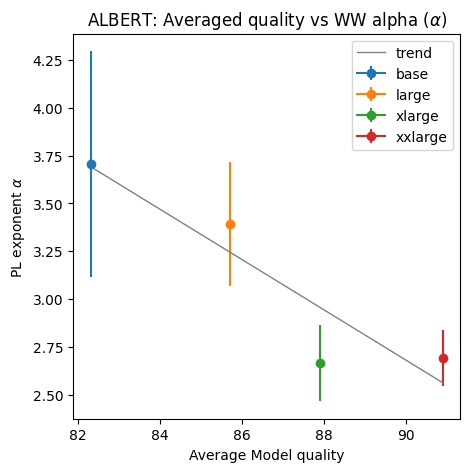

In [21]:
x_s, y_s, w_s = [], [], []

for idx, details in enumerate(all_details):
    version = versions[idx]
    mean_quality = mean_qualities[idx]
    
    D = details[(details.alpha < 10) & (details.alpha > 1.5)]
    
    alphas = D.alpha.to_numpy()
    weights = 1.0/D.sigma.to_numpy()
    
    alpha = np.average(alphas, weights=weights)
    sigma = D.sigma.mean()
    
    plt.errorbar(mean_quality, alpha, yerr=sigma, label=version, marker='o')
    
    x_s.append(mean_quality)
    y_s.append(alpha)
    w_s.append(sigma)
    
plt.legend()
plt.title(r"ALBERT: Averaged quality vs WW alpha $(\alpha)$")
plt.ylabel(r"PL exponent $\alpha$")
plt.xlabel("Average Model quality")

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
trend = linear_model.LinearRegression()
x_s = np.array(x_s).reshape(-1, 1)
y_s = np.array(y_s).reshape(-1, 1)
w_s = np.array(w_s)

model = trend.fit(x_s, y_s)# w_s)  weights probably not rght and have no effect here
y_pred = trend.predict(x_s)
plt.plot(x_s, y_pred, color='gray', linewidth=1, label='trend')
plt.legend()



Text(0.5, 0, 'Layer Id (Data -> Labels)')

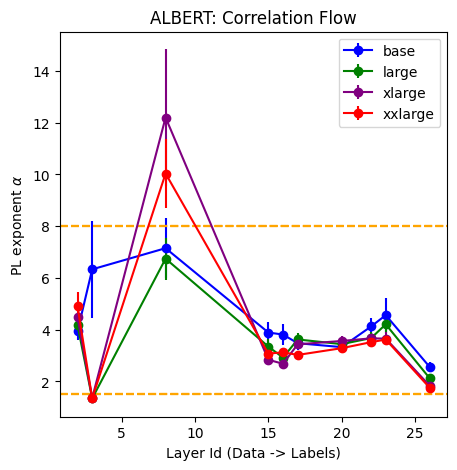

In [22]:
for idx, details in enumerate(all_details):
    color = colors[idx]
    version = versions[idx]
    
    D = details
        
    x = D.layer_id.to_numpy()
    y = D.alpha.to_numpy()
    err = D.sigma.to_numpy()
    plt.errorbar(x, y, yerr=err, label=version, marker='o', color=color)
    plt.axhline(1.5, color='orange', linestyle='dashed')
    plt.axhline(8, color='orange', linestyle='dashed')

plt.legend()
plt.title(r"ALBERT: Correlation Flow")
plt.ylabel(r"PL exponent $\alpha$")
plt.xlabel("Layer Id (Data -> Labels)")

### Lets compare the PL fits from all 4 models

In [23]:
%%capture 

all_esds = []
all_alphas = []
for version in versions:
    model_name = f"albert-{version}-v2"
    albert = AlbertModel.from_pretrained(model_name)

    watcher = ww.WeightWatcher(model=albert)
    esd = watcher.get_ESD(layer=17)
    all_esds.append(esd)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': Tru

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': False, 'min_evals': 0, 'max_evals': None, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 17
INFO:weightwatcher:Getting ESD for layer 17 


### We can see that the tail of the ESD is somewhat distored in the base, and as we approach xxlarge, the Layer 17 ESD becomes more regular

And, yet, with Layer 17, there remains a single outlier eigenvalue which is clipped



In [40]:
def plot_loghist(axis, x, label, color=color):
    hist, bins = np.histogram(x, bins=100)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    axis.hist(x, bins=logbins, density=True, color=color, alpha=0.25, label=label)
    axis.set_xscale('log')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


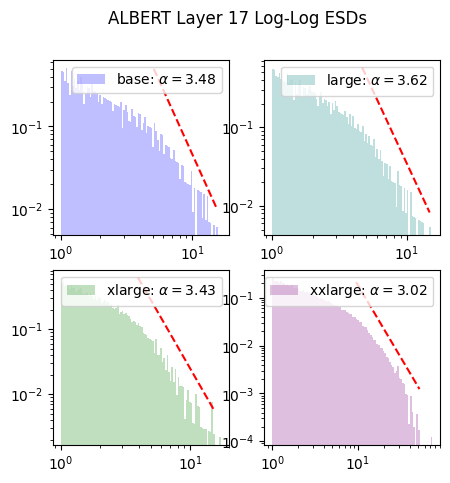

In [51]:
import powerlaw
fig, axs = plt.subplots(2, 2)
axes = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
colors = ['blue', 'teal', 'green', 'purple']
for idx, version in enumerate(versions):
    
    D = all_details[idx]
    D = D[D.layer_id==17]
    alpha = D.alpha.to_numpy()[0]
    
    esd = all_esds[idx]
    axis = axes[idx]
    color = colors[idx]
    
    label = version+r": $\alpha=$"+f"{alpha:0.2f}"
    
    plot_loghist(axis, esd[esd>1], label, color=colors[idx])
    axis.legend(loc='upper right')
    
    fit = powerlaw.Fit(esd, xmax=esd[-2])
    fit.power_law.plot_pdf(color='r', linestyle='--', ax=axis)
fig.suptitle('ALBERT Layer 17 Log-Log ESDs ')
plt.show()


### The last layer in ALBERT has alpha < 2 ... lets dig into that now


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [26], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 26


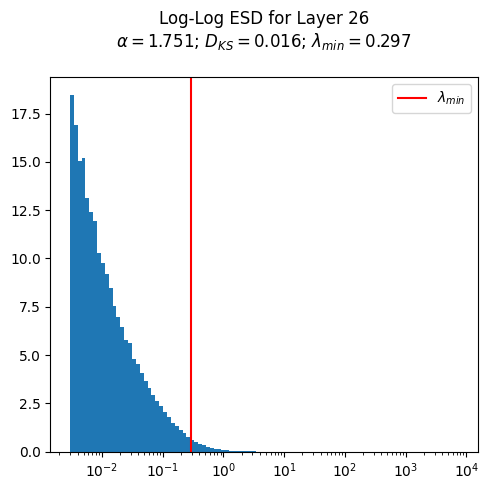

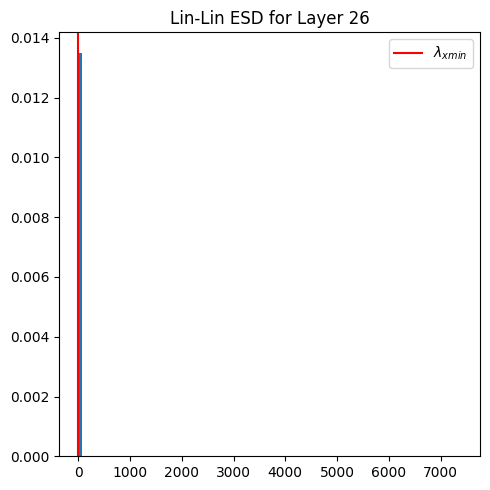

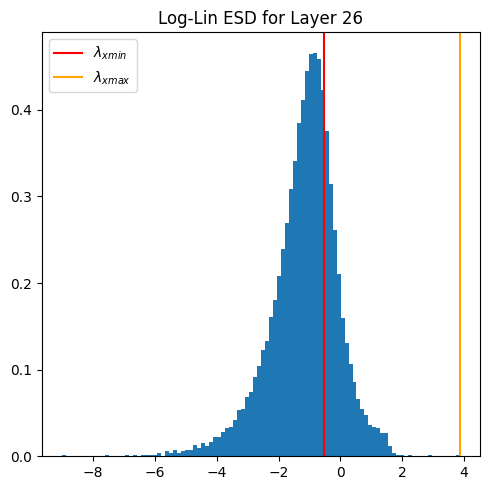

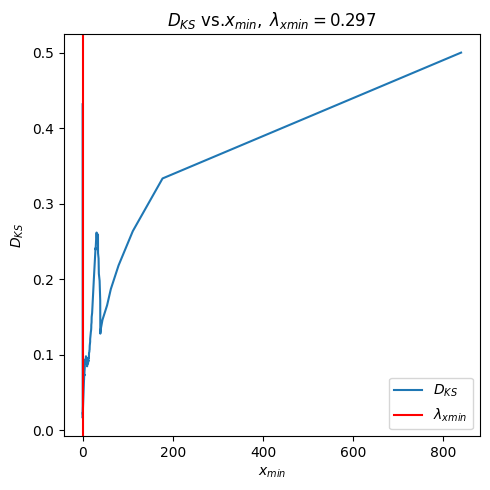

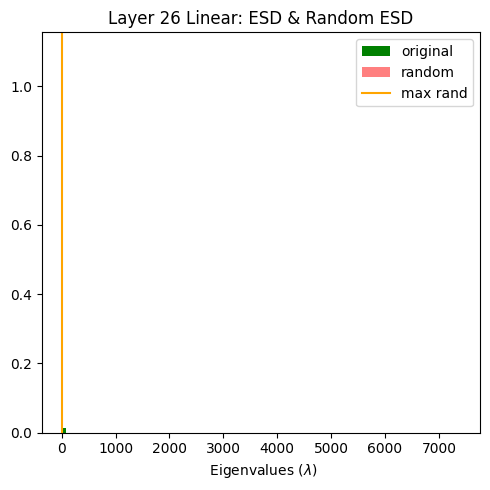

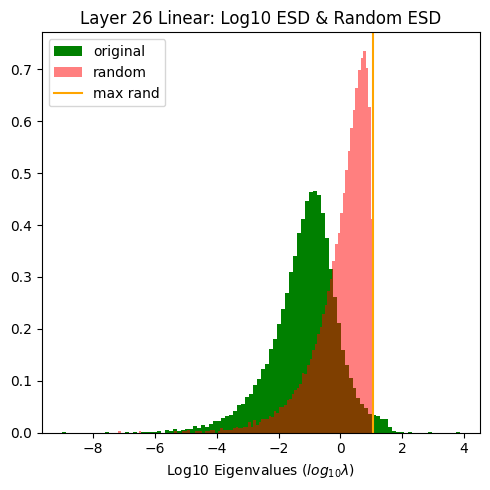

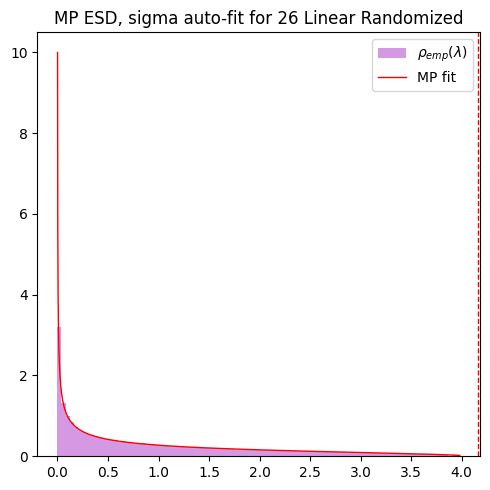

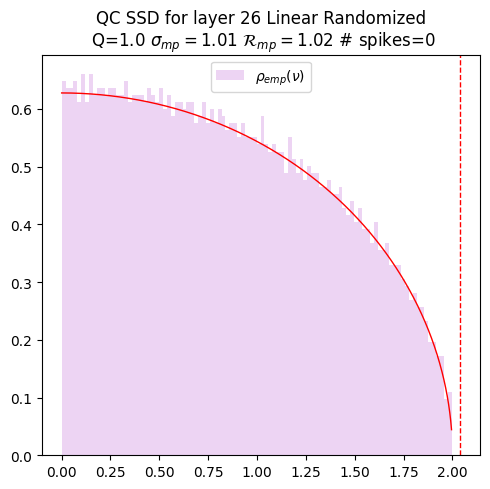

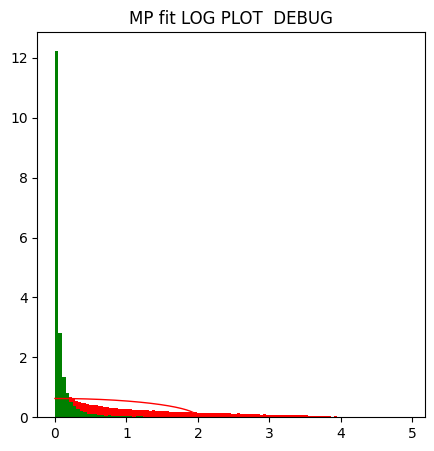

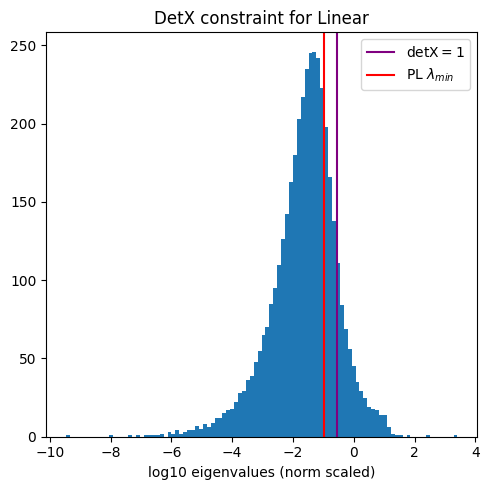

,layer_id,name,D,Lambda,M,N,Q,alpha,alpha_weighted,best_fit,...,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,26,Linear,0.015998,-1.0,4096.0,4096.0,1.0,1.751392,6.775845,lognormal,...,0.022896,7393.230881,1.60426,85.983899,over-trained,7.0,7381.651075,0.001566,7393.230881,0.297144


<Figure size 500x500 with 0 Axes>

In [52]:
watcher.analyze(layers=[26], plot=True, randomize=True, detX=True)

In [53]:
esd = watcher.get_ESD(layer=26)

INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': False, 'min_evals': 0, 'max_evals': None, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'f

### The last layer in ALBERT has some 'fingers' sticking out

The red line is at the 10th eigenvalue from the top

This has been noticed by Hinton also (http://proceedings.mlr.press/v97/kornblith19a.html), and appears to be an artifact of the last layer being close to the labels

Text(0, 0.5, 'Density')

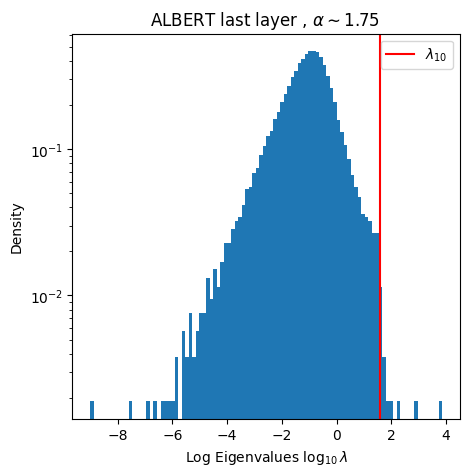

In [54]:
plt.hist(np.log10(esd), bins=100, log=True, density=True);
plt.axvline(np.log10(esd[-10]), color='red', label=r"$\lambda_{10}$");
plt.title(r"ALBERT last layer , $\alpha\sim1.75$ ")
plt.legend()
plt.xlabel(r"Log Eigenvalues $\log_{10}\lambda$")
plt.ylabel("Density")

### If we cut off the last few eigenvalues,  alpha does not change much

Which is a good sign for the stabilty

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  clip_xmax
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': 'clip_xmax', 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [26], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Fixing fingers using  clip_xmax
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2
INFO:weightwatcher:Filtering layer by id 26
INFO:weightwatcher:fix the fingers by fitting a clipped power 

max N = 10
Calculating best minimal value for power law fit


Assuming nested distributions
INFO:weightwatcher:fit alpha 1.75 sigma 0.02 TPL or PL? 0.5521


Assuming nested distributions
INFO:weightwatcher:2 fit alpha 1.7629 sigma 0.0241 TPL or PL? 1.5622
INFO:weightwatcher:2 fit alpha 1.76 sigma 0.02 TPL or PL? 1.5622


stopping at min alpha = 1.76
checking alpha


INFO:weightwatcher:checking fit 3 xmax 177.3112  alpha 1.76 sigma 0.02


INFO:weightwatcher:checking fit 4 xmax 111.3506  alpha 1.76 sigma 0.02


INFO:weightwatcher:checking fit 5 xmax 79.7800  alpha 1.76 sigma 0.02


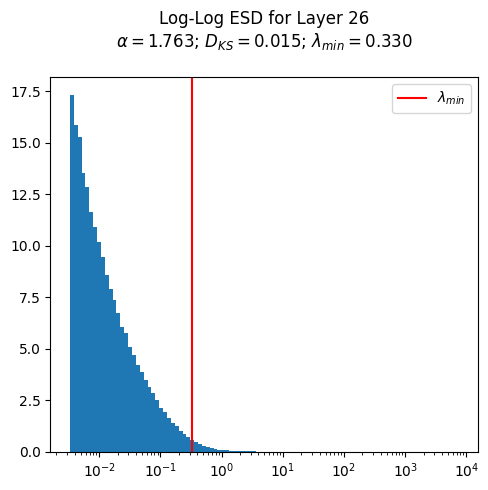

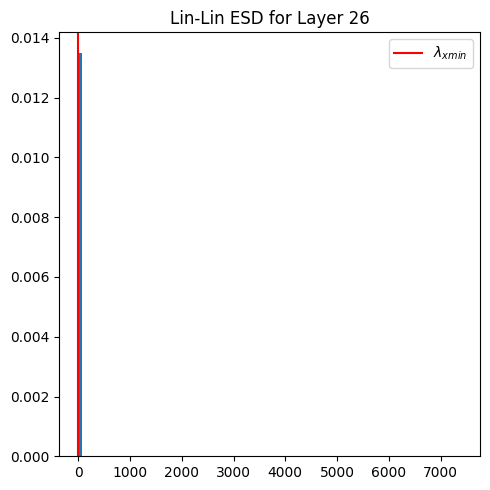

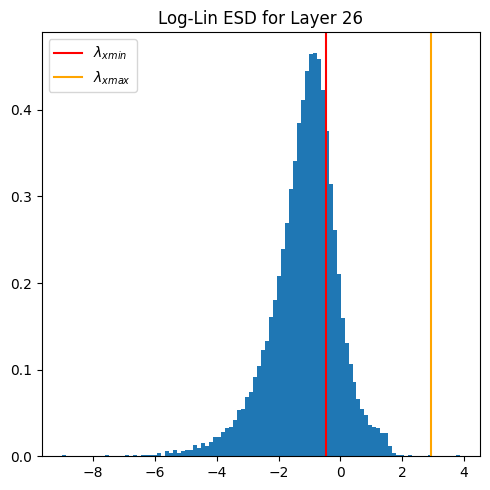

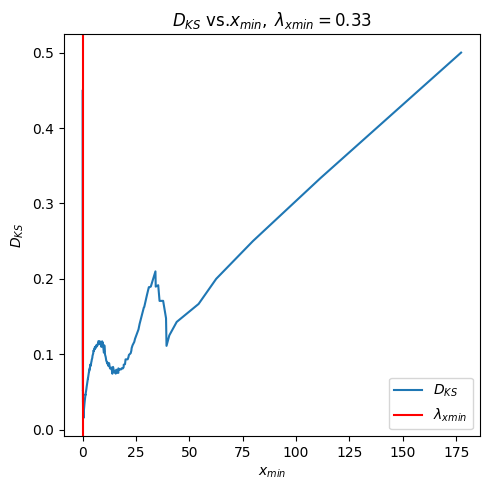

,layer_id,name,D,Lambda,M,N,Q,alpha,alpha_weighted,best_fit,...,rank_loss,rf,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,xmax,xmin
0,26,Linear,0.015352,-1.0,4096.0,4096.0,1.0,1.762901,6.82037,power_law,...,0.0,1.0,0.024101,7393.230881,1.60426,85.983899,over-trained,7.0,839.468487,0.330324


<Figure size 500x500 with 0 Axes>

In [55]:
watcher.analyze(layers=[26], fix_fingers='clip_xmax', plot=True)